In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from helperFunctions import createDataSet

# Load the datasets
file = "../../data/Ohio2020_processed/train/540-ws-training_processed.csv"
train_file = "../../data/Ohio2020_processed/train/540-ws-training_processed.csv"
test_file = "../../data/Ohio2020_processed/test/540-ws-testing_processed.csv"
train_data = createDataSet(train_file)
test_data = createDataSet(test_file)

# Data Preparation
def prepare_data(data, time_steps=3):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].drop("cbg", axis=1).values)
        y.append(data.iloc[i + time_steps]["cbg"])
    return np.array(X), np.array(y)

# Combine all sub-dataframes from createDataSet output
train_data_combined = pd.concat(train_data, axis=0).reset_index(drop=True)
test_data_combined = pd.concat(test_data, axis=0).reset_index(drop=True)

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
train_data_combined_scaled = pd.DataFrame(scaler.fit_transform(train_data_combined), columns=train_data_combined.columns)
test_data_combined_scaled = pd.DataFrame(scaler.transform(test_data_combined), columns=test_data_combined.columns)

# Prepare the data for LSTM
X_train, y_train = prepare_data(train_data_combined_scaled)
X_test, y_test = prepare_data(test_data_combined_scaled)




Epoch 1/20
35/35 [==============================] - 2s 16ms/step - loss: 0.0779 - val_loss: 0.0212
Epoch 2/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0239 - val_loss: 0.0158
Epoch 3/20
35/35 [==============================] - 0s 5ms/step - loss: 0.0170 - val_loss: 0.0132
Epoch 4/20
35/35 [==============================] - 0s 5ms/step - loss: 0.0147 - val_loss: 0.0151
Epoch 5/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0139 - val_loss: 0.0162
Epoch 6/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0130 - val_loss: 0.0227
Epoch 7/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0126 - val_loss: 0.0189
Epoch 8/20
35/35 [==============================] - 0s 5ms/step - loss: 0.0121 - val_loss: 0.0234
Epoch 9/20
35/35 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0218
Epoch 10/20
35/35 [==============================] - 0s 5ms/step - loss: 0.0107 - val_loss: 0.0262
Epoch 11/20
35/35 

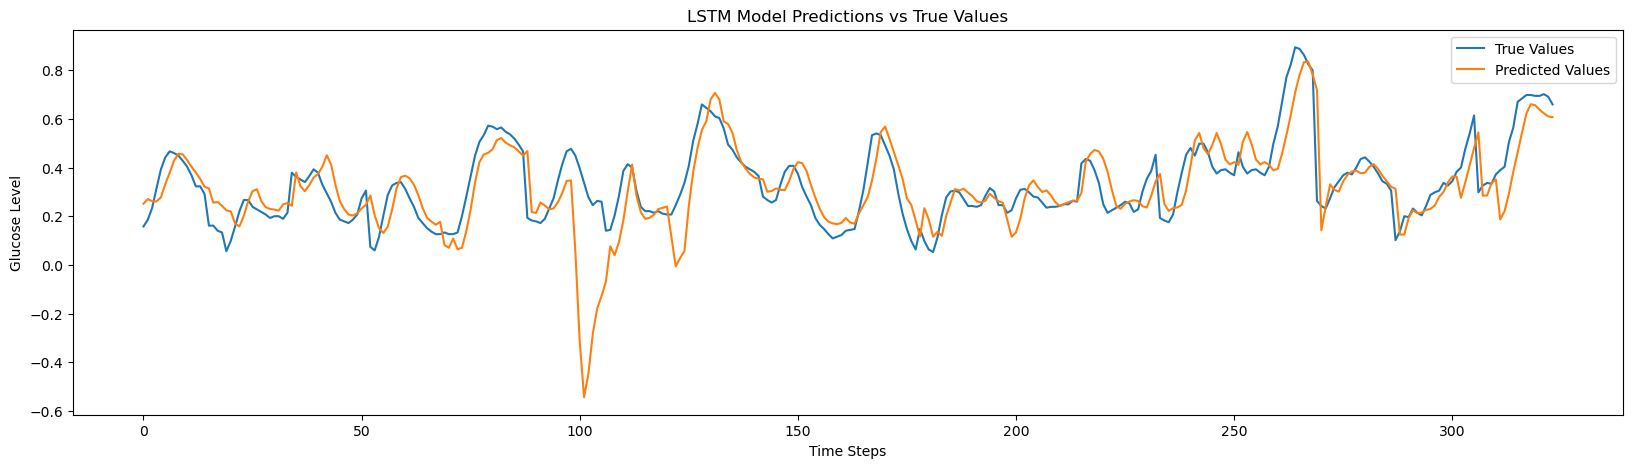

In [2]:
# LSTM Model Definition
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Train the LSTM model
input_shape = (X_train.shape[1], X_train.shape[2])
lstm_model = create_lstm_model(input_shape)
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Make predictions
y_train_pred = lstm_model.predict(X_train)
y_test_pred = lstm_model.predict(X_test)

# Inverse transform predictions and true values
y_train_pred_inv = scaler.inverse_transform(np.concatenate([y_train_pred, np.zeros((y_train_pred.shape[0], train_data_combined.shape[1] - 1))], axis=1))[:, 0]
y_test_pred_inv = scaler.inverse_transform(np.concatenate([y_test_pred, np.zeros((y_test_pred.shape[0], test_data_combined.shape[1] - 1))], axis=1))[:, 0]
y_train_inv = scaler.inverse_transform(np.concatenate([y_train.reshape(-1, 1), np.zeros((y_train.shape[0], train_data_combined.shape[1] - 1))], axis=1))[:, 0]
y_test_inv = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], test_data_combined.shape[1] - 1))], axis=1))[:, 0]

# Plot results
plt.figure(figsize=(20, 5))
plt.plot(y_test_inv, label="True Values")
plt.plot(y_test_pred_inv, label="Predicted Values")
plt.xlabel("Time Steps")
plt.ylabel("Glucose Level")
plt.title("LSTM Model Predictions vs True Values")
plt.legend()
plt.show()